In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def create_original_dataframe():
    original_df = pd.read_csv('../data/all_financial_with_keywords.csv') 
    original_df = original_df.drop_duplicates()
    return original_df

original_df = create_original_dataframe()

### Prep Target Column
def prep_target_variable(original_df, column='diff'):
    # Convert to percent based deltas
    original_df['open'] = original_df[column] + original_df['close']
    original_df['diff_percent'] = original_df[column] / original_df['close']
    
   # Remove the over 100% change values
    final_df = original_df[(original_df['diff_percent'] > -1.0) & (original_df['diff_percent'] < 1.0)]
    return final_df

original_df = prep_target_variable(original_df)
target_column = 'diff_percent'

### Setup Bank Column Group and Dataframe
bank_columns = [
    'citigroup', 'citi', 'morgan stanley', 'ubs', 'barclays', 'wells fargo', 
    'goldman sachs', 'deutsche bank', 'credit suisse', 'merrill lynch', 
    'rbc capital', 'jefferies', 'stifel', 'morgan stanley.1', 'merrill lynch.1', 
    'goldman sachs.1', 'raymond james', 'piper jaffray', 'robert w. baird', 
    'william blair', 'william blair.1', 'hill road', 'document_length', 'word_count', target_column
]
bank_df = original_df[bank_columns]
bank_df.head()

,citigroup,citi,morgan stanley,ubs,barclays,wells fargo,goldman sachs,deutsche bank,credit suisse,merrill lynch,...,goldman sachs.1,raymond james,piper jaffray,robert w. baird,william blair,william blair.1,hill road,document_length,word_count,diff_percent
0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1400564,121073,0.029333
1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1101155,89042,-0.002051
2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1101155,89042,0.000000
3,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.0,6.0,NaN,NaN,NaN,NaN,2325972,90097,0.004995
4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3297190,123802,-0.007323


# Group 1: Bank Name Counts

This data is the count of a bank name appearance in an ipo prospectus document.

## Cleaning

1. Fill NA values with 0, as NA just means the keyword was not present in document.

In [7]:
### Convert NA to 0
bank_df = bank_df.fillna(0)

### Remove Dupes
dupes = [
    'morgan stanley.1',
    'merrill lynch.1',
    'goldman sachs.1',
    'william blair.1'
]

for dupe in dupes:
    if not dupe in bank_df:
        continue
    root_name=dupe.split('.')[0]
    bank_df[root_name] = bank_df[root_name] + bank_df[dupe]
    bank_df = bank_df.drop(dupe, axis=1)

## Bank Name Count Distribution

The initiall hypothesis for this type of data was a Poisson, random events in time or space. These are word counts in a document, and one document does not affect the next. The null hypothesis is accepted in this case that no Poisson is present. And even further distribution testing has confirmed that this group does not have a standard statistical distribution.

H(0) = No Poisson Distribution H(1) = Poisson Distribution
Significance Level = 0.05 Experiment: Kolmogorov-Smirnov test comparing observed data to theoretical Poisson distribution Result: P_Value = 0.0 for all columns in group

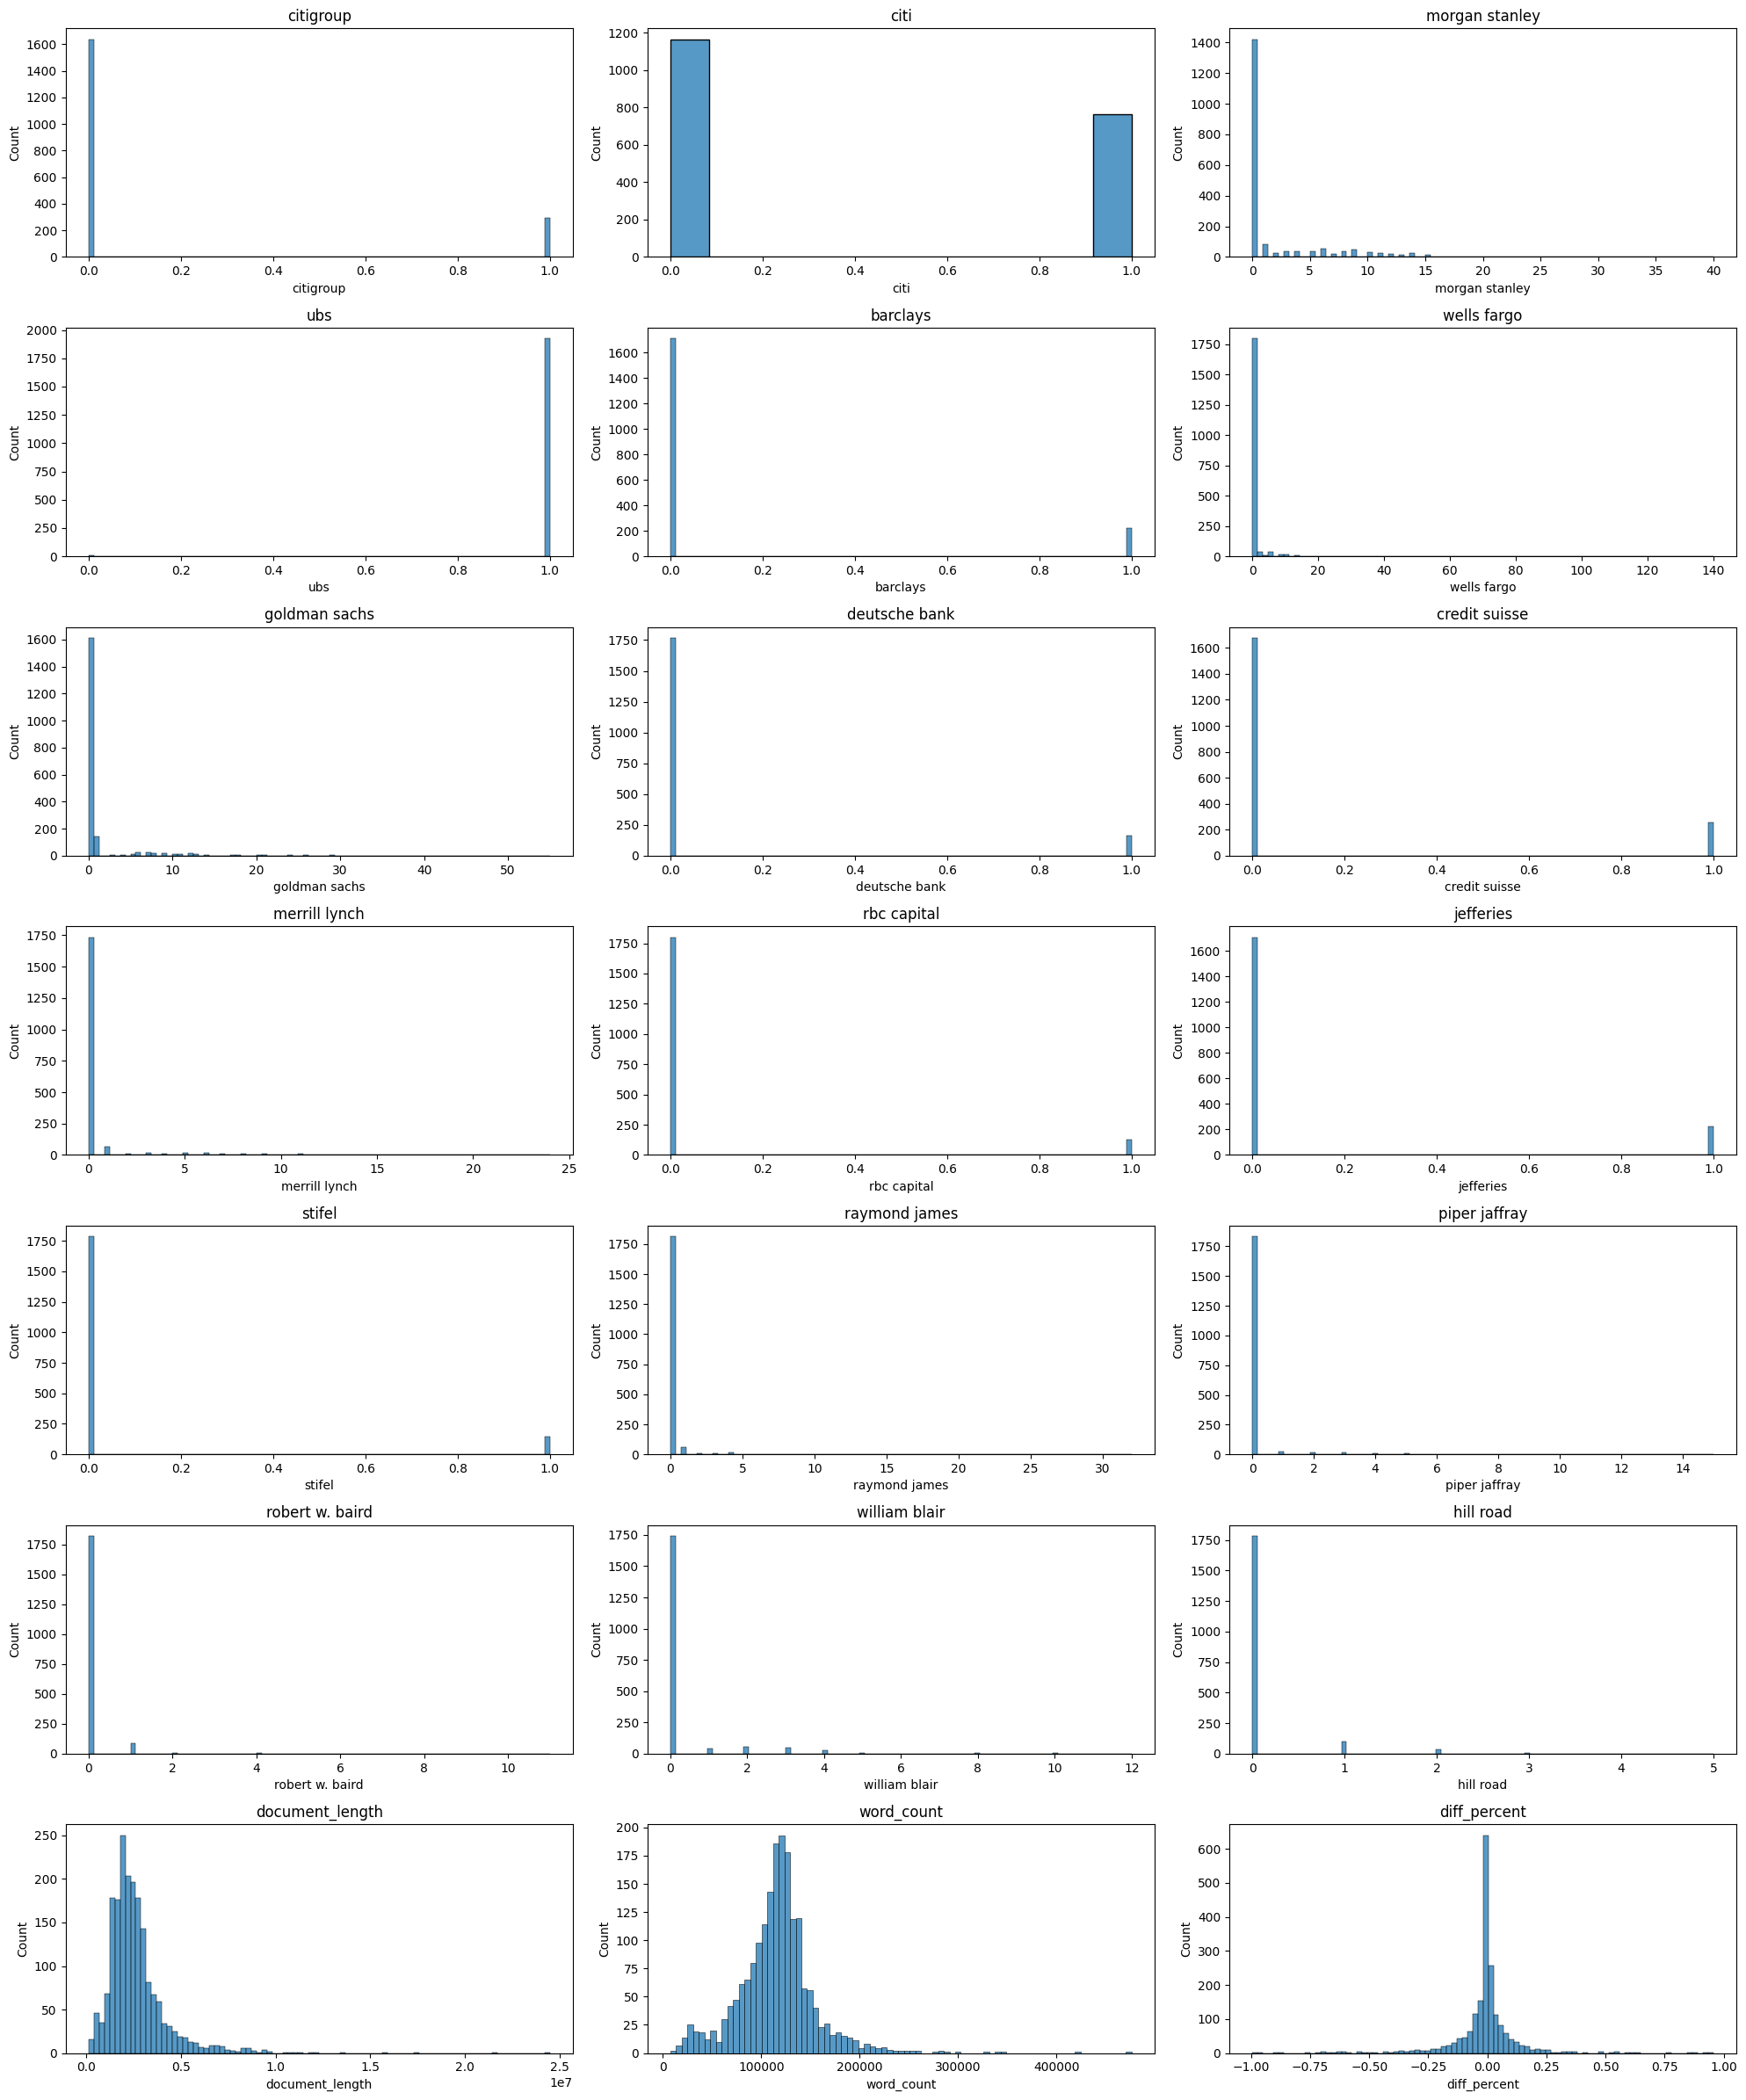

In [8]:
### View Distributions
cols=bank_df.columns
n = len(cols)

n_rows = 7
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 24))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    sns.histplot(data=bank_df, x=col, ax=ax)
    ax.set_title(col)

for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [4]:
### Attempt Poisson Proof

row_list = []

for bank_name in bank_df.columns:
    data = bank_df[bank_name]
    
    mean = data.mean()
    variance = data.var()
    ratio = variance / mean

     # Skip if all zeros or constant
    if data.std() == 0:
        print(f"Skipping {bank_name}: No variation in data")
        continue
    
    lambda_param = mean
    alpha = 0.05
    try:
        ks_stat, p_value = stats.kstest(data, 
                                       lambda x: stats.poisson.cdf(x, lambda_param))
    except:
        ks_stat, p_value = np.nan, np.nan
    
    row_list.append({
        'bank': bank_name,
        'positive_ints': all(data >= 0) and all(data == data.astype(int)),
        'mean': mean,
        'variance': variance,
        'ratio': ratio,
        'strong poisson': abs(ratio - 1) < 0.1,
        'overdispersed': ratio > 1.5,
        'underdispersed': ratio < 0.8,
        'ks_stat': ks_stat,
        'p_value': p_value,
        'reject poisson': p_value < alpha
    })
poisson_df = pd.DataFrame(row_list)
print(poisson_df)

print(f"Contains only integers: {all(data == data.astype(int))}")

               bank  positive_ints          mean      variance         ratio  \
0         citigroup           True  1.508554e-01  1.281645e-01  8.495851e-01   
1              citi           True  3.960601e-01  2.393206e-01  6.042531e-01   
2    morgan stanley           True  1.872473e+00  1.713207e+01  9.149435e+00   
3               ubs           True  9.974080e-01  2.586639e-03  2.593361e-03   
4          barclays           True  1.135303e-01  1.006934e-01  8.869295e-01   
5       wells fargo           True  5.816485e-01  1.523724e+01  2.619664e+01   
6     goldman sachs           True  1.039917e+00  1.415868e+01  1.361520e+01   
7     deutsche bank           True  8.398134e-02  7.696837e-02  9.164938e-01   
8     credit suisse           True  1.311560e-01  1.140132e-01  8.692946e-01   
9     merrill lynch           True  5.391395e-01  5.046315e+00  9.359944e+00   
10      rbc capital           True  6.739243e-02  6.288329e-02  9.330913e-01   
11        jefferies           True  1.14

## Feature Scale

Determine if there is a difference between promincence (magnitude) and presence (at least 1 count). This would help determine if the data should be scaled to binary values or use some other method. Given there is not a standard distribution present, and the data is significatly 0 inflated, it is hard to simply apply something such as a log function.

The result concluded that it depened on the bank name. Therefore, leaving the scale as is seems to be the best approach.

In [5]:
count_correlations = bank_df.corr(method='spearman')[target_column]
count_correlations

citigroup          0.052804
citi               0.021379
morgan stanley     0.035748
ubs                0.033168
barclays           0.047654
wells fargo        0.034651
goldman sachs      0.046650
deutsche bank      0.032785
credit suisse      0.083881
merrill lynch      0.030064
rbc capital        0.032621
jefferies          0.032975
stifel             0.024775
raymond james     -0.000643
piper jaffray     -0.007113
robert w. baird    0.050070
william blair      0.038413
hill road         -0.014890
document_length    0.017059
word_count         0.056878
diff_percent       1.000000
Name: diff_percent, dtype: float64

In [6]:
binary_mentions = (bank_df > 0).astype(int)
binary_correlations = binary_mentions.corr(method='spearman')[target_column]
binary_correlations

citigroup          0.043715
citi               0.016414
morgan stanley     0.046799
ubs                0.023660
barclays           0.032624
wells fargo        0.046902
goldman sachs      0.030426
deutsche bank      0.027862
credit suisse      0.062885
merrill lynch      0.033855
rbc capital        0.029789
jefferies          0.036245
stifel             0.006694
raymond james      0.020701
piper jaffray     -0.024397
robert w. baird    0.050399
william blair      0.039566
hill road         -0.006311
document_length         NaN
word_count              NaN
diff_percent       1.000000
Name: diff_percent, dtype: float64

In [7]:
# Difference between correlations
difference = binary_correlations - count_correlations
performance_retained = binary_correlations / count_correlations

comparison_df = pd.DataFrame({
    'count_corr': count_correlations,
    'binary_corr': binary_correlations,
    'difference': difference,
    'H(0) Accepted': difference != 0,
    'Prominent': difference < 0,
    'Presence': difference > 0
})
comparison_df

,count_corr,binary_corr,difference,H(0) Accepted,Prominent,Presence
citigroup,0.052804,0.043715,-0.009089,True,True,False
citi,0.021379,0.016414,-0.004965,True,True,False
morgan stanley,0.035748,0.046799,0.011051,True,False,True
ubs,0.033168,0.023660,-0.009509,True,True,False
barclays,0.047654,0.032624,-0.015030,True,True,False
wells fargo,0.034651,0.046902,0.012251,True,False,True
goldman sachs,0.046650,0.030426,-0.016223,True,True,False
deutsche bank,0.032785,0.027862,-0.004923,True,True,False
credit suisse,0.083881,0.062885,-0.020996,True,True,False
merrill lynch,0.030064,0.033855,0.003791,True,False,True


## Outliers

Data is has a zero inflated nature, so all values seem like an outlier. Nothing sticks out visualy either, so this will be left alone.

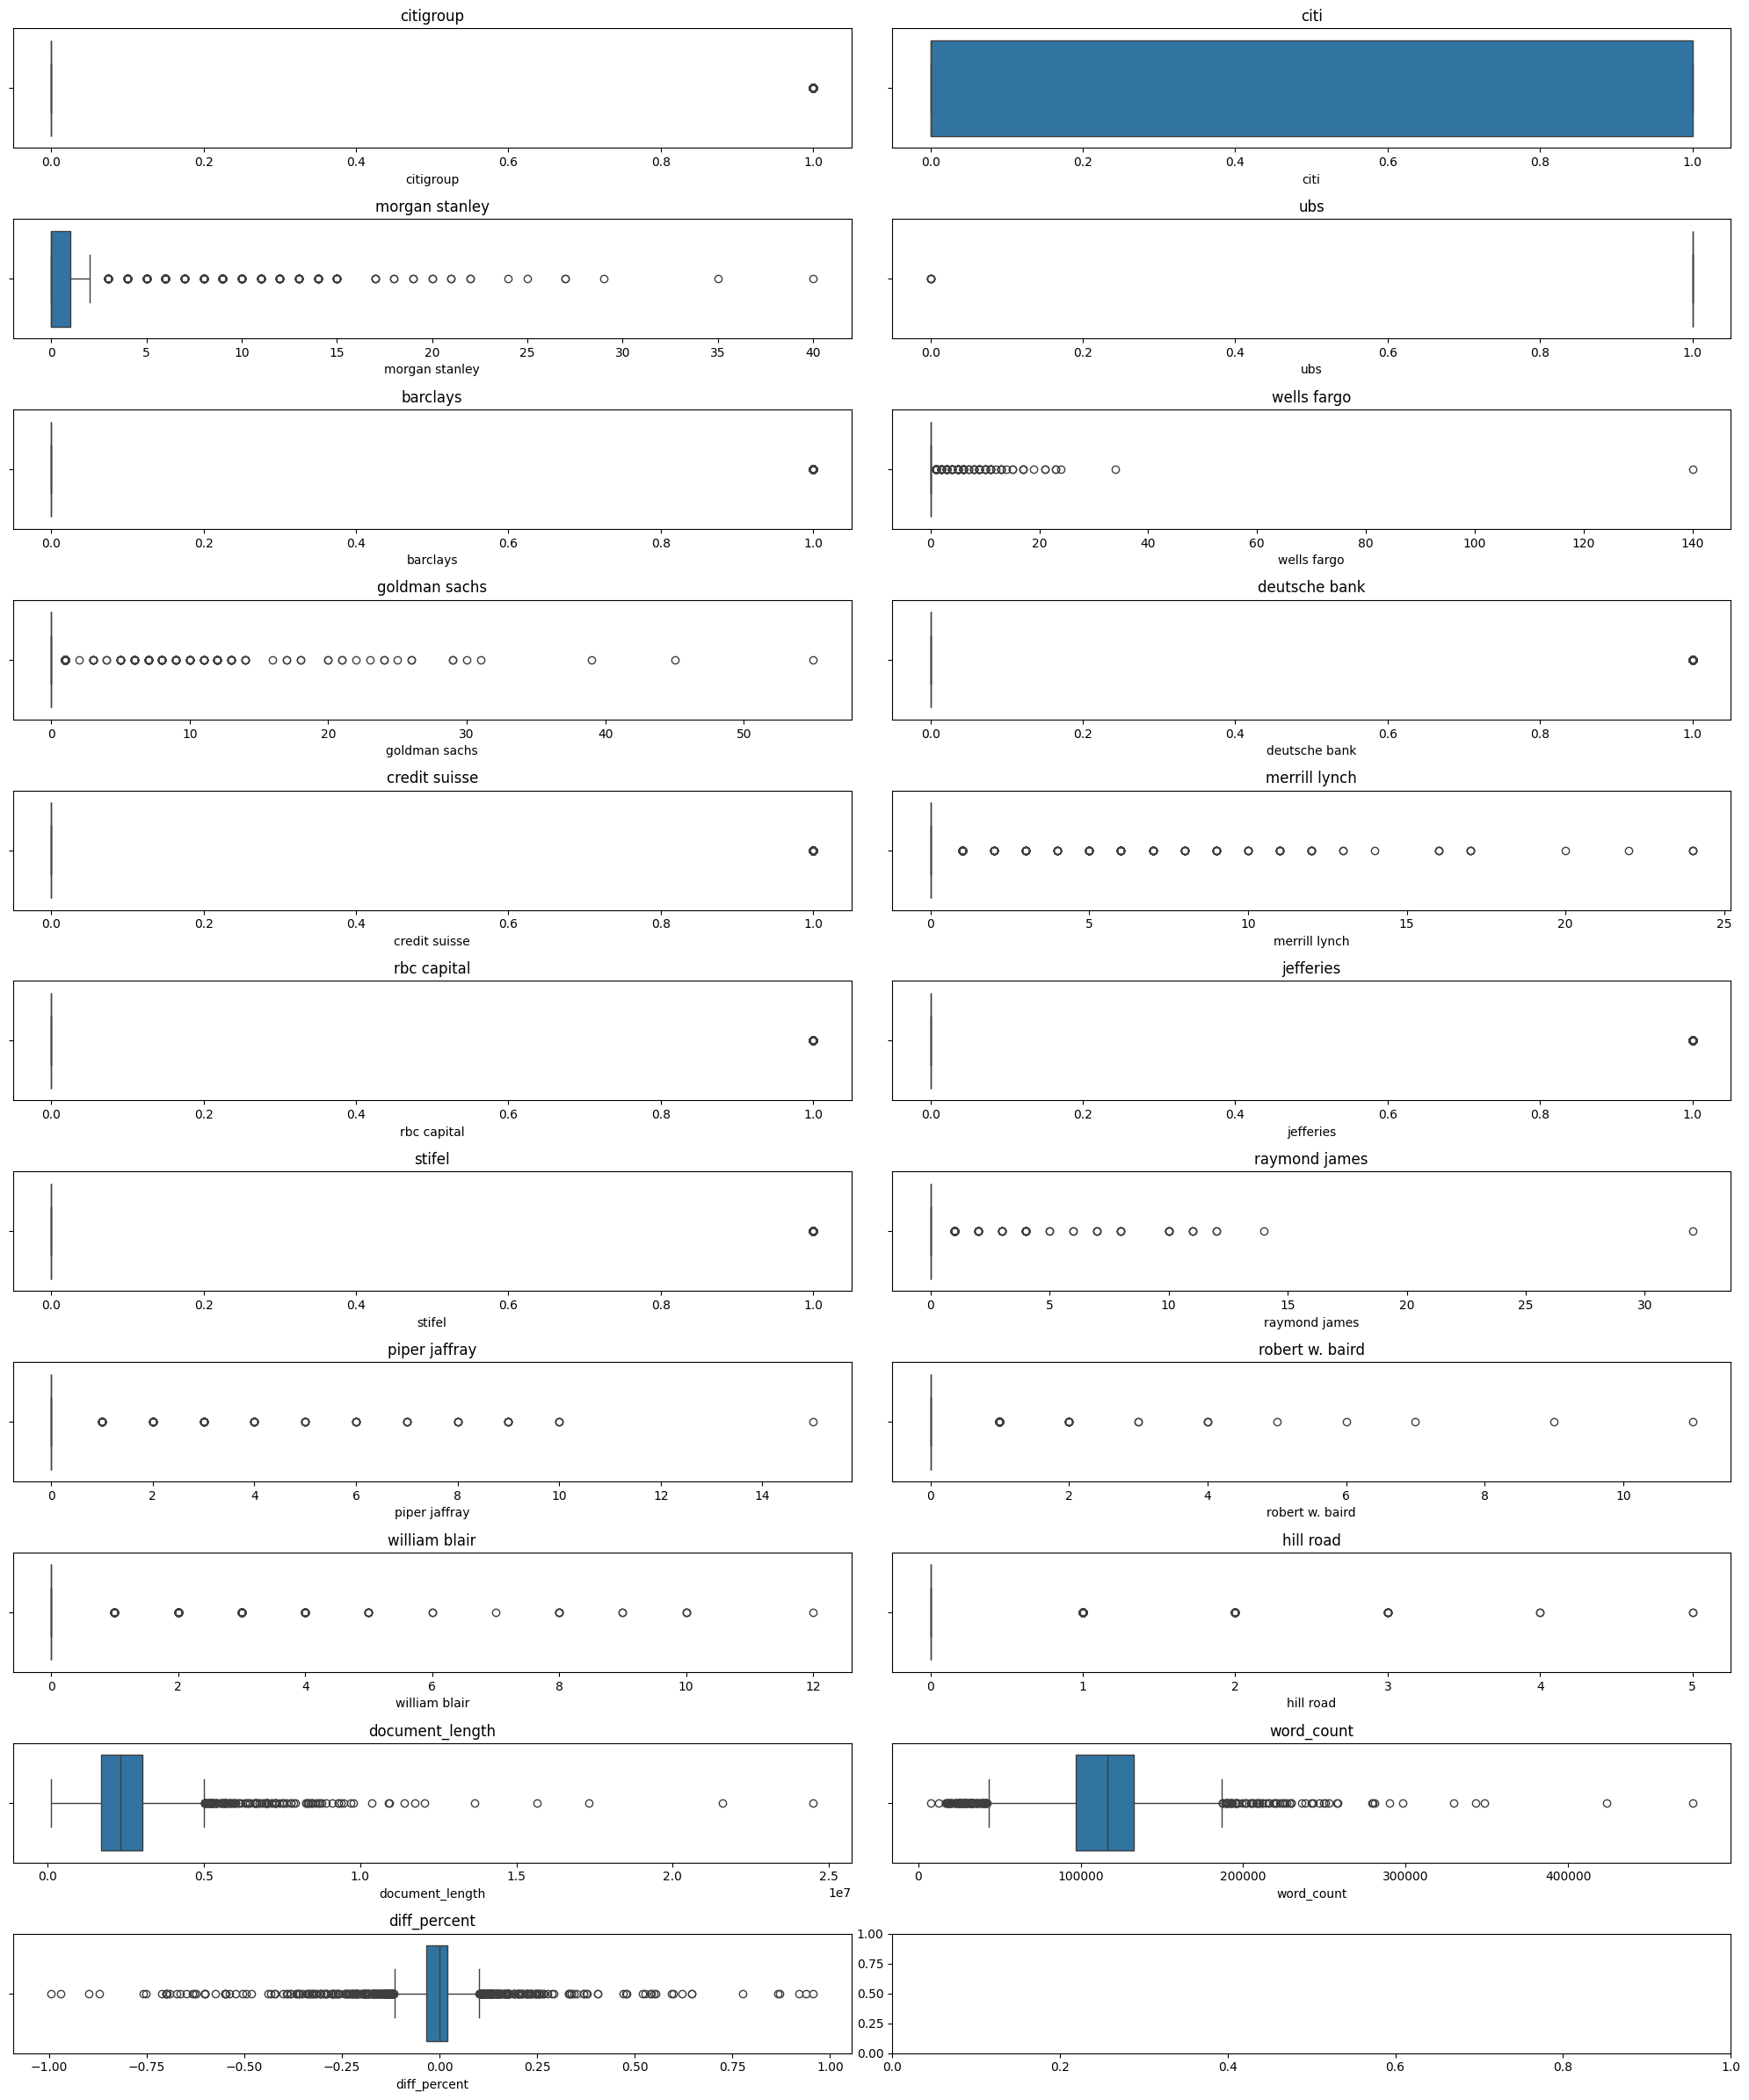

In [8]:
# Create Box Plots
cols=bank_df.columns
n = len(cols)

n_cols = 2
n_rows = 11

fig, axes = plt.subplots(n_rows, n_cols, figsize=[20,24])
axs = axes.flatten()

for ax, col in zip(axs, cols):
    sns.boxplot(x=bank_df[col], ax=ax)
    ax.set_title(col)

for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

## Feature Engineering

1. Give each bank a numberical index, and then one hot encode the ones in the row into a group called 'bank_group'
2. Total banks present in row as 'unique_bank_count'
3. Add a document_length ratio
4. Add a parallel column that transforms to a log1p for stability

In [18]:
### Bank Group Column

### Convert to binary data
df = bank_df.drop('diff_percent', axis=1)

### Create a one hot encoding as group
cols = list(df.columns)

def encode_bank_name(bank_name):
    return cols.index(bank_name) 

df['bank_group'] = df.apply(lambda row: [col for col, val in row.items() if val >= 1 and col != 'word_count' and col != 'document_length'], axis=1)
df['bank_group'] = df['bank_group'].apply(lambda row: [encode_bank_name(bank) for bank in row])
print(df['bank_group'])

0       [0, 1, 2, 3, 4]
1                   [3]
2                   [3]
3        [1, 3, 13, 14]
4                   [3]
             ...       
2018         [3, 5, 13]
2019             [1, 3]
2020             [1, 3]
2021                [3]
2022             [1, 3]
Name: bank_group, Length: 1929, dtype: object


In [19]:
### Unique Bank Count Column

df['unique_bank_count'] = df['bank_group'].apply(lambda row: len(row))

In [20]:
### Add Document Length to Count Ratio

for col in df.columns:
    if col == 'bank_group' or col == 'word_count' or col == 'document_length' or col == 'unique_bank_count':
        continue
    new_col = f'{col}-word-count-ratio'
    df[new_col] = df[col]/df['word_count']
print(df.columns)

Index(['citigroup', 'citi', 'morgan stanley', 'ubs', 'barclays', 'wells fargo',
       'goldman sachs', 'deutsche bank', 'credit suisse', 'merrill lynch',
       'rbc capital', 'jefferies', 'stifel', 'raymond james', 'piper jaffray',
       'robert w. baird', 'william blair', 'hill road', 'document_length',
       'word_count', 'bank_group', 'unique_bank_count',
       'citigroup-word-count-ratio', 'citi-word-count-ratio',
       'morgan stanley-word-count-ratio', 'ubs-word-count-ratio',
       'barclays-word-count-ratio', 'wells fargo-word-count-ratio',
       'goldman sachs-word-count-ratio', 'deutsche bank-word-count-ratio',
       'credit suisse-word-count-ratio', 'merrill lynch-word-count-ratio',
       'rbc capital-word-count-ratio', 'jefferies-word-count-ratio',
       'stifel-word-count-ratio', 'raymond james-word-count-ratio',
       'piper jaffray-word-count-ratio', 'robert w. baird-word-count-ratio',
       'william blair-word-count-ratio', 'hill road-word-count-ratio'],
   

In [22]:
### Add Parallel Log1p Column For Raw Bank Counts

for col in df.columns:
    if col == 'bank_group' or col == 'word_count' or col == 'document_length' or col == 'unique_bank_count' or 'word-count-ratio' in col:
        continue
    new_col = f'{col}-log1p'
    df[new_col] = np.log1p(df[col])

print(df.columns)

In [3]:
### Final Algorithmn

def prepare_bank_count_feature(df):
    ### Convert NA to 0
    bank_df = df.fillna(0)

    ### Remove Dupes
    dupes = [
        'morgan stanley.1',
        'merrill lynch.1',
        'goldman sachs.1',
        'william blair.1'
    ]

    for dupe in dupes:
        if not dupe in bank_df:
            continue
        root_name=dupe.split('.')[0]
        bank_df[root_name] = bank_df[root_name] + bank_df[dupe]
        bank_df = bank_df.drop(dupe, axis=1)
        
    ### Feature Engineer Bank Group Column
    cols = list(bank_df.columns)
    # Remove non bank name columns, check if column has a value
    bank_df['bank_group'] = bank_df.apply(lambda row: [col for col, val in row.items() if val >= 1 and col != 'word_count' and col != 'document_length'], axis=1)
    # Encoded value of bank name is it's index in the cols list 
    bank_df['bank_group'] = bank_df['bank_group'].apply(lambda row: [cols.index(bank_name) for bank_name in row])

    ### Feature Engineer Unique Bank Count
    # Count the length of the bank_groups array, which is the numerical list of columns that have at least one count
    bank_df['unique_bank_count'] = bank_df['bank_group'].apply(lambda row: len(row))

    ### Feature Engineer Bank Count Ratios
    for col in bank_df.columns:
        if col == 'bank_group' or col == 'word_count' or col == 'document_length' or col == 'unique_bank_count':
            continue
        new_col = f'{col}-word-count-ratio'
        bank_df[new_col] = bank_df[col]/df['word_count']

    ### Feature Engineer Parallel Log1p Column
    for col in bank_df.columns:
        if col == 'bank_group' or col == 'word_count' or col == 'document_length' or col == 'unique_bank_count' or 'word-count-ratio' in col:
            continue
        new_col = f'{col}-log1p'
        bank_df[new_col] = np.log1p(bank_df[col])   
        

    return bank_df

bank_columns = [
    'citigroup', 'citi', 'morgan stanley', 'ubs', 'barclays', 'wells fargo', 
    'goldman sachs', 'deutsche bank', 'credit suisse', 'merrill lynch', 
    'rbc capital', 'jefferies', 'stifel', 'morgan stanley.1', 'merrill lynch.1', 
    'goldman sachs.1', 'raymond james', 'piper jaffray', 'robert w. baird', 
    'william blair', 'william blair.1', 'hill road', 'document_length', 'word_count'
]
bank_df = original_df[bank_columns]

final_df = prepare_bank_count_feature(bank_df)
final_df.columns

Index(['citigroup', 'citi', 'morgan stanley', 'ubs', 'barclays', 'wells fargo',
       'goldman sachs', 'deutsche bank', 'credit suisse', 'merrill lynch',
       'rbc capital', 'jefferies', 'stifel', 'raymond james', 'piper jaffray',
       'robert w. baird', 'william blair', 'hill road', 'document_length',
       'word_count', 'bank_group', 'unique_bank_count',
       'citigroup-word-count-ratio', 'citi-word-count-ratio',
       'morgan stanley-word-count-ratio', 'ubs-word-count-ratio',
       'barclays-word-count-ratio', 'wells fargo-word-count-ratio',
       'goldman sachs-word-count-ratio', 'deutsche bank-word-count-ratio',
       'credit suisse-word-count-ratio', 'merrill lynch-word-count-ratio',
       'rbc capital-word-count-ratio', 'jefferies-word-count-ratio',
       'stifel-word-count-ratio', 'raymond james-word-count-ratio',
       'piper jaffray-word-count-ratio', 'robert w. baird-word-count-ratio',
       'william blair-word-count-ratio', 'hill road-word-count-ratio',
    